<a href="https://colab.research.google.com/github/marilynbraojos/transformer_demo/blob/main/gpt_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit: Andrej Karpathy

*Note: This is not exactly what Andrej Karpathy released and I've modified the way the notebook looks so that it can more closely match with my application of a transformer model (i.e. adding detailed comments, adjusting parameters, adding notes to refer to at a later time, plotting).* However, he was the OG creator of this idea and code, therefore he deserves credit.

# Loading and Characterizing Data


In this model, we will be using a toy dataset called Tiny Shakespeare. This dataset contains 40,000 lines of Shakespeare from a variety of his plays. The Tiny Shakespeare dataset has a manageable size, and the complexity of Shakespeare's language.

In [1]:
# Access the dataset used for training using the "web get" command !wget

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# Count the number of lines in input.txt - Confirm Number of Lines
!wc -l input.txt

--2024-04-09 15:05:43--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.6’

input.txt.6         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-04-09 15:05:43 (18.5 MB/s) - ‘input.txt.6’ saved [1115394/1115394]

40000 input.txt


We will be modeling how these characters follow one another. The transformer model will try to produce character sequences that look like this following the patterns in this data. Once the model is trained, we will generate Shakespeare-like writing. In contrast to ChatGPT, our model will be producing writing on a character-by-character level - whereas ChatGPT produces this in a token-by-token level, where their tokens were "sub-word" pieces.

In [2]:
# read in text as a string in to inspect it

with open('input.txt', 'r', encoding='utf-8') as f:                             # open input.txt in read mode, 'r'
    text = f.read()

This shows that we are working with ≈ 1M characters:

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


Below,


```
set(text)                   % contains unique elements (characters) from the "text"

list(set(text))             % converts the set into a list (preserves order of the elements)

sorted(list(set(text)))     % sorts list in ascending order (default)

```



In [4]:
 # here are all the unique characters that occur in this text

chars = sorted(list(set(text)))
vocab_size = len(chars)                                                         # return numer of character elements
print(''.join(chars))                                                           # join the characters from 'chars' into a single string without a separator between them, concatenating them into one string
print(vocab_size)                                                               # possible elements/characters of our sequence


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


# Step 1: Tokenizing Input Text

Tokenization breaks a stream of data into a meaningful element (words, terms, sentences, symbols, etc). It breaks unstructured data into chunks of discrete elements. In this case, it involves converting the raw text as a string to a sequence of integers according to some vocabulary of possible elements. In our case, we're doing this at the character level because we are creating a character-level model.


Reference: https://neptune.ai/blog/tokenization-in-nlp

*Personal Note: I think "encode" and "decode" are poor names for these operations because it can lead to confusion with encoder/decoder in the context of a transformer but c'est la vie*

Other schemas: Google's SentencePiece (sub-word tokenizer that doesn't encode entire words, but also not only character), OpenAI's tiktoken (bi-pair encoding). Sub-word tokenizers are commonly what's used in practice.

In [5]:
 # create a mapping from characters to integers by creating a look up table from character to integer and vice versa

stoi = { ch:i for i,ch in enumerate(chars) }                                      # create string to integer dictionary where each unique character, ch, from the 'chars' list is mapped to its corresponding index in the list
itos = { i:ch for i,ch in enumerate(chars) }                                      # create integer to string dictionary where each unique index, i, is mapped to its corresponding character, 'ch,' in the 'chars' list
encode = lambda s: [stoi[c] for c in s]                                           # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l])                                  # decoder: take a list of integers, output a string

# lambda functions are anonymous, one-line functions in the syntax: lambda args: expression

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [6]:
# encode the entire text dataset and store it into a torch.Tensor
import torch
import torch.nn as nn
from torch.nn import functional as F                                             # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)

# encode(text) converts all of the Shakespeare dataset text from string to integers.
# torch.tensor creates a tensor from the list of integers obtained from the encoding. This is a multi-dimensional matrix with elements of a single data type.
# torch.long corresponds to 64-bit integers.
# reference: https://pytorch.org/docs/stable/tensors.html

print(data.shape, data.dtype)
print(data[:1000])                                                               # the first 1000 characters we looked at earlier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

From this point, the data is now represented by integers.

# Step 2: Split Data into Train/Test Sets

In [7]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data))                                                          # first 90% will be train, rest val

# len(data) >> returns length of the 'data' tensor
# 0.9*len(data) >> calculates 90% of the total length of the data. This results in a floating-point value of the index up to the first 90% of the data to be considered for model training
# int(0.9*len(data)) >> converts floating-point value to an integer. This rounds down the floating-point value to the nearest integer. This ensures that we can use this as a valud index value.

train_data = data[:n]                                                           # first 'n' elements
val_data = data[n:]                                                             # last 1-n elements

In [8]:
len(train_data)                                                                 # number of sample in the training dataset

1003854

# Step 3: Loading the Data for Our Model to Use

## Set Hyperparameters

In [9]:
# hyperparameters
batch_size = 16                                                                 # how many independent sequences will we process in parallel?
block_size = 32                                                                 # what is the maximum context length for predictions?
max_iters = 5000                                                                # maximum number of training iterations (after max_iters, training is done)
eval_interval = 100                                                             # this is how often we evaluate our model's performance on the test set (so every 100 iterations, we produce a loss value)
learning_rate = 1e-3                                                            # step size for optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64                                                                     # size of embedding vectors for tokens or features
n_head = 4                                                                      # attention heads (# of parallel attention mechanisms)
n_layer = 4                                                                     # layers in architecture - depth of model
dropout = 0.0                                                                   # dropout used

We are not going be feeding the entire text to the transformer all at once (too computationally expensive/prohibitive). Therefore, when we train the transformer, we're really only using chunks of the data to do this at a time. These chunks have a max length. This is known as the *block size*. This is in the time dimension of the tensors fed into the transformer.

In [10]:
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1])


 In this case, in the context of 18, we see 47 comes next, in the context of 18 and 47, 56 comes next. In the context of 18, 47, 56, then 57 likely comes next, and so on. The purpose of this is to get our transformer used to seeing context as little as 1 to as much as block_size, and everything in between. After block_size, we start truncating because the transformer will never see more than block_size inputs when predicting the next character. This is demonstrated below:

In [11]:
x = train_data[:block_size]                                                      # inputs to the transformer (x block size characters)
y = train_data[1:block_size+1]                                                   # starts from the second element up to block size amount characters (these are the targets for each position in the input; the next block size characters). These are our predictions
for t in range(block_size):                                                      # loop to iterate "block_size" times where the loop variable, 't', takes values from 0 to block_size-1
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47, 58]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47]) the target: 64
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64]) the target: 43
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43]) the target: 52
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52]) the target: 10
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10]) the target: 0
when input is tensor([18, 47, 56, 57, 58,  1, 15, 

As we sample these chunks of text, we're going to have many batches of multiple chunks of text stacked in a single tensor for parallel data processing. These chunks are processed independently and do not communicate with each other. This is the *batch dimension*.

## Create data batches

In [12]:
torch.manual_seed(1337)                                                           # set random seed for PyTorch's random number generator https://pytorch.org/docs/stable/generated/torch.manual_seed.html

def get_batch(split):                                                             # create function named 'get_batch' and it takes in a single arg, 'split'

    # generates a small batch of data of inputs x and targets y

    data = train_data if split == 'train' else val_data                           # selecting the data set to generate batch from. if split arg is 'train,' then train_data set is used, else val_data set is used. this returns our data array
    ix = torch.randint(len(data) - block_size, (batch_size,))                     # determine random positions to grab chunks out of. generate random indices to select the sequences from the data set. number of indices generated equal the 'batch_size' and the indices are chosen randomly within the range of the dataset boundaries. returns a tensor filled with random integers generated uniformly between low (inclusive) and high (exclusive). therefore, this generates batch_size numbers of random offsets, so ix are 4 numbers randomly generated between len(data) - block size. https://pytorch.org/docs/stable/generated/torch.randint.html
    x = torch.stack([data[i:i+block_size] for i in ix])                           # first block size characters starting at i. construct input tensor, x, by selecting sequences of length of the block size from the dataset based on the random indices ix. this forms the inputs for the batch.
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])                       # constructs ^ for the targets - ^ offset by 1
    x, y = x.to(device), y.to(device)
    return x, y                                                                   # return x and y as a tuple

xb, yb = get_batch('train')                                                       # obtains batch of training data
print('inputs to trasformer:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size):                                                      # batch dimension
    for t in range(block_size):                                                  # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs to trasformer:
torch.Size([16, 32])
tensor([[58, 53,  1, 41, 53, 56, 56, 59, 54, 58,  1, 39,  1, 51, 39, 52,  5, 57,
          1, 61, 47, 44, 43,  1, 47, 57,  0, 61, 46, 43, 52,  1],
        [49,  1, 39, 52,  1, 53, 39, 58, 46,  1, 40, 63,  1, 20, 47, 51,  6,  0,
         32, 46, 43,  1, 59, 52, 47, 58, 63,  1, 58, 46, 43,  1],
        [59, 50, 42,  1, 58, 46, 53, 59,  1, 61, 43, 56, 58,  1, 57, 53,  1, 58,
         53, 53,  2,  0,  0, 24, 33, 15, 21, 27, 10,  0, 35, 43],
        [ 8,  0,  0, 35, 13, 30, 35, 21, 15, 23, 10,  0, 28, 56, 53, 60, 43,  1,
         47, 58,  6,  1, 20, 43, 52, 56, 63,  6,  1, 39, 52, 42],
        [58,  1, 57, 46, 43,  8,  0,  0, 32, 30, 13, 26, 21, 27, 10,  0, 18, 53,
         56,  1, 61, 46, 39, 58,  1, 56, 43, 39, 57, 53, 52,  6],
        [56, 61, 47, 41, 49,  6,  1, 50, 43, 58,  1, 47, 58,  1, 40, 43, 11,  0,
         18, 53, 56,  1, 47, 52,  1, 58, 46, 63,  1, 57, 46, 53],
        [25, 10,  0, 35, 47, 58, 46, 42, 56, 39, 61,  1, 63, 53, 59,  1, 46

A 4 × 8 array above would give us 32 examples (gives us cases where we can say "when the input is #, the target is #; when the input is #, #, the target is #). They're completely independent as far as transformer is concerned. These are 32 indepedent examples packed into a single batch. This integer tensor of x will feed into the transformer, and it will simultaneously process all these examples.

# Step 4: Creating the Transformer Model

Note: *The simple bigram model will not perform well because the tokens are NOT talking to each other. This is where the transformer will help.*

## Generating Bigram Model Class

We'll start by building a bigram model - one of the simplest neural networks.

For more information on bigram model: https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-language-model-nlp-python-code/#:~:text=A%20bigram%20language%20model%20is,in%20a%20text%20or%20sentence.

In a classification ML task, cross-entropy loss (aka log loss or softmax loss) is the employed loss function. This is the difference between the projected probability distribution and the actual proability distribution of the target classes. In this case, we have ID of next character so this evaluates quality of prediction wrt to target. Correct dim of logits should yield high value, and other dims low. Because we have 65 possible vocabulary elements, we can guess loss as: $-ln(1/65)=4.17$. If the loss value is higher than our "guess," meaning our predictions are a bit more diffuse.

See more: https://www.educative.io/answers/what-is-cross-entropy-loss-in-pytorch.

Lecture 28 ML

Softmax Function: Turns vector of K real values into a vector of K real values that sum to 1. The inputs can be +, , 0, or greater than 1 but the softmax transforms them into values between 0 and 1, so that they can be interpreted as probabilities. See more: https://deepai.org/machine-learning-glossary-and-terms/softmax-layer#:~:text=The%20softmax%20function%20is%20a,can%20be%20interpreted%20as%20probabilities.


Softmax($x_i$) = $\frac{e^{x_i}}{∑_j e^{x_j}}$

In [13]:
@torch.no_grad()                                                                # decorator; disable gradient computation to avoid the gradients of other batches accumulating or impacting the gradient of the previous batch
def estimate_loss():                                                            # evaluate loss on training and test
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)                                        # initialize losses tensor for the evaluation iterations
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)                                          # compute logits and loss for selected batch
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In transformers, dependencies between sequences is established through self-attention.

Dropout layers enable our model to avoid overfitting. Dropout is a regularization technique for neural networks

In [14]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()

        # apply linear transformation to input data https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.key = nn.Linear(n_embd, head_size, bias=False)                     # importance of each position relative to other positions in sequence
        self.query = nn.Linear(n_embd, head_size, bias=False)                   # determines focus area when generating output
        self.value = nn.Linear(n_embd, head_size, bias=False)                   # content/info at each position
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):                                                       # forward pass
        B,T,C = x.shape
        k = self.key(x)                                                         # (B,T,C)
        q = self.query(x)                                                       # (B,T,C)

        # compute attention scores ("affinities") between query and key representations

        wei = q @ k.transpose(-2,-1) * C**-0.5                                  # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))            # (B, T, T); Applying this mask prevents the model from "cheating" and attending to future positions in the sequence. Elements in the attention score matrix for future positions is replaced with -inf so that attention is only allowed to losst or past or current positions in the sequence
        wei = F.softmax(wei, dim=-1)                                            # (B, T, T); normalize weights
        wei = self.dropout(wei)                                                 # dropout regularization: https://www.google.com/search?q=adding+dropout+layers&rlz=1C5CHFA_enUS737US737&oq=adding+dropout+layers+&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIICAEQABgWGB4yCAgCEAAYFhgeMg0IAxAAGIYDGIAEGIoFMg0IBBAAGIYDGIAEGIoFMg0IBRAAGIYDGIAEGIoFMg0IBhAAGIYDGIAEGIoFMg0IBxAAGIYDGIAEGIoF0gEINDU2M2owajeoAgCwAgA&sourceid=chrome&ie=UTF-8

        # perform the weighted aggregation of the values
        v = self.value(x)                                                       # (B,T,C)
        out = wei @ v                                                           # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out


In [15]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)                                   # projects concatenated output back to embedding dimension
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [16]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [17]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


In [18]:
class BigramLanguageModel(nn.Module):                                             # using nn.Module enables us to use PyTorch's neural network capabilities; this is the base for all neural network models https://pytorch.org/docs/stable/generated/torch.nn.Module.html

    def __init__(self, vocab_size):
        super().__init__()

        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)         # create embedding table to map token indices to corresponding embedding vector https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html. Arg: vocab_size
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])    # this is where the transformer block is called
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)


    # predicting what comes next based on previous token only
    def forward(self, idx, targets=None):                                         # this method must be implemented under "nn.Module" and it defines how input data is processed through the network (incl activation functions, transformations, etc).
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)

        # idx and targets are both (B,T) tensor of integers
        logits = self.lm_head(x) # (B,T,vocab_size)                                # (B: batch, T: tokens, C: classes); retrieve embedding vectors. logits = scores

        if targets is None:
            loss = None
        else:                                                                     # if targets are provided the cross-entropy loss between the predicted logits and the actual targets is computed; otherwise the loss is none
            B, T, C = logits.shape                                                # define as idx to match cross-entropy function expected input
            # reshaping to match cross entropy function inputs
            logits = logits.view(B*T, C)                                          # convert to a 2D tensor [row: logits for specific token in the batch for all time steps, col: logits for the different classes (in this case vocab_size, which is 65)]
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)                               # https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html

        return logits, loss                                                       # logist = raw score

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):                                           # predict the new tokens based on the context of the previous token; note to self: '_' can be used when variable name is not relevant within the loop
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]                                             # becomes (B, C) ; the -1 represents the selection o the last element along this dim (the sequence length)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)                                     # (B, C); applying the softmax function to the logits (ensure they sum to 1 along the classes dimension) https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)                    # (B, 1); draw one sample for each probability distribution https://pytorch.org/docs/stable/generated/torch.multinomial.html
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)                    # concatenates tensor
        return idx

# Step 5: Train and Validate Model

## Selecting an Optimizer

In deep learning, we want to update the learning rate so that we can perform reasonable updates. Adam (adaptive moment estimation) is a standard optimization learning algo for training DNNs.

In [19]:
model = BigramLanguageModel(vocab_size)
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

0.209729 M parameters


In [20]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [21]:
# preallocate memory
train_losses = []
val_losses = []

In [22]:
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_loss = losses['train']
        val_loss = losses['val']
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # append losses to the lists for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.4049, val loss 4.3996
step 100: train loss 2.6715, val loss 2.6830
step 200: train loss 2.5027, val loss 2.4981
step 300: train loss 2.4163, val loss 2.4299
step 400: train loss 2.3453, val loss 2.3580
step 500: train loss 2.3025, val loss 2.3216
step 600: train loss 2.2374, val loss 2.2534
step 700: train loss 2.2067, val loss 2.2190
step 800: train loss 2.1565, val loss 2.1788
step 900: train loss 2.1162, val loss 2.1491
step 1000: train loss 2.0877, val loss 2.1191
step 1100: train loss 2.0555, val loss 2.1081
step 1200: train loss 2.0215, val loss 2.0705
step 1300: train loss 2.0099, val loss 2.0499
step 1400: train loss 1.9754, val loss 2.0217
step 1500: train loss 1.9512, val loss 2.0187
step 1600: train loss 1.9321, val loss 2.0204
step 1700: train loss 1.9278, val loss 2.0058
step 1800: train loss 1.8854, val loss 1.9831
step 1900: train loss 1.8746, val loss 1.9619
step 2000: train loss 1.8637, val loss 1.9739
step 2100: train loss 1.8482, val loss 1.9534


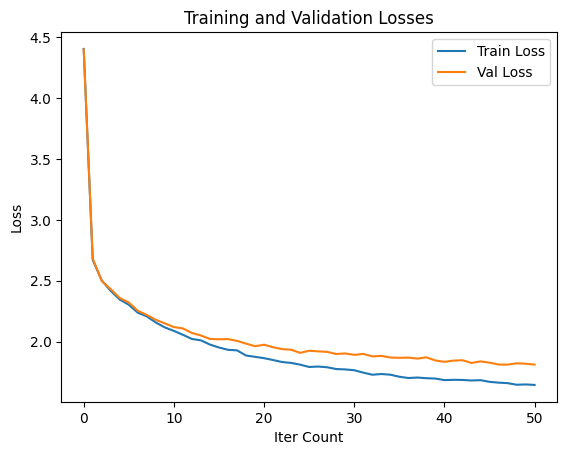

In [23]:
import matplotlib.pyplot as plt

steps = range(max_iters//eval_interval+1)  # x-axis values (steps)
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Val Loss')
plt.xlabel('Iter Count')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [24]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


And farmen:
Therefore us; come hard It Dome,
This to our sweet might, or that must springs to but too?

First Lord, Parge to, thyse Is bland,
se thou companish he thus mind; his by betwereignt, tho, guines do rith.

KING EDWARD IV:
What shall your sI a hard,---love.

POLIXENES:
Why, with the will be as
by thou sover conurse
Wetwould pity.

KING RICHARD II:
gold,
Thuntle of you, was me; an your tought
Of najeckingling to-does, and little spright.

GLOUCESTER:
Roman made; I godve his is brother be slory.
Nay! if the stable:
Of where as suses, passes us.

LUCENTIO:
He ratherefords throw and praader?

DUKE VINCENTIO:
Offights thou love the confert late a with thy self,
Ofly us beltragin mady kingmand Her foul his foll busine.
Proker, prinried Andlescupingrate:
By for my sick? Io, was myself!

Secragespet the gatious I'll:
The conching-sconcears at and havelget
well bear confath with me. Him you, profired take
Apase, names bonul straving yonger's cleave
Will him Rivisted in his slope.

Ben

## The mathematical trick in self-attention

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below